In [1]:
""" Code to compute some very basic quantities for HW2
    As is it applies the code to existing runs.
    Students get to modify it to apply to their own run or another run of interest
"""

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors
import glob

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr

# Variables in this script TOM = Top of Model is the model equivalent of Top of Atmosphere
FSNT = absorbed shortwave at TOM \
FSNTC = absorbed shortwave at TOM under clear sky \
FLNT = outgoing longwave at TOM \
FLNTC = outgoing longwave at TOM under clear sky \
TREFHT = 2 m temperature \
PRECT = total precipitation	\

In [2]:
def fixmonth(dfile):

    """Fix CESM months since by default the timestamp is for the first day of
    the next month

    Parameters
    ----------

    dfile : xarray dataset
            Dataset containing time to fix

    Returns
    -------

    dfile : xarray dataset
            Fixed dataset
    """

    mytime = dfile['time'][:].data
    for time in range(mytime.size):
        if mytime[time].month > 1:
            mytime[time] = mytime[time].replace(month=mytime[time].month-1)
        elif mytime[time].month == 1:
            mytime[time] = mytime[time].replace(month=12)
            mytime[time] = mytime[time].replace(year=mytime[time].year-1)

    dfile = dfile.assign_coords(time=mytime)

    return dfile
    
def compute_global(da,gw): # multiply by so-called Gaussian weights that oddly enough sum to 2
    globalmean=(da.mean(dim='lon')*gw).sum(dim='lat')/2
    return globalmean


def compute_global_means(username,case,exper):
    print('Getting data for ',username)
    fields=['FSNT','FLNT','FSNTC','FLNTC','TREFHT','PRECC','PRECL']
    thedict = {}

    if username=='CMIP6':
        dsc=[]
        for thevar in fields:
            # get all years since we initialized our experiments, but averaging done over last 20 yrs only. Wish we could run longer
            if exper=='piControl':
                ncfile='/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/'+case+'/atm/proc/tseries/month_1/'+case+'.cam.h0.'+thevar+'.030101-035012.nc'
                ds=xr.open_dataset(ncfile)
                ds=fixmonth(ds)
                ds=ds.sel(time=slice('0321-01', '0350-12'))
            elif exper=='QuadrupleCO2':
                ncfile='/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/'+case+'/atm/proc/tseries/month_1/'+case+'.cam.h0.'+thevar+'.000101-005012.nc'
                ds=xr.open_dataset(ncfile)
                ds=fixmonth(ds)
                ds=ds.sel(time=slice('0001-01', '0030-12'))
            da=ds[thevar]
            da.name=thevar
            if thevar=='FSNT':
                dsc=ds['gw']
            dsc=xr.merge((dsc, da))
            themap=da.isel(time=range(120,360)).mean(dim='time')
            thedict[thevar]=(compute_global(themap,ds.gw)).values
    
    else:
        print('Gathering data from your run for all years possible from 10-29, this could be slow. Edit here if you want to change it.')
        ncfile=sorted(glob.glob('/glade/derecho/scratch/'+username+'/archive/'+case+'/atm/hist/'+case+'.cam.h0.00[1-2]*.nc'))
        dsc=xr.open_mfdataset(ncfile)
        dsc=fixmonth(dsc) # not needed but good for peace of mind
        gw=dsc.gw.isel(time=0)
        dsc = dsc[np.append(fields, 'gw')]
        for thevar in fields:
            themap=dsc[thevar].mean(dim='time')
            thedict[thevar]=(compute_global(themap,gw)).values

    thedict['imbalanceTOM']=thedict['FSNT']-thedict['FLNT']
    thedict['PRECT']=thedict['PRECC']+thedict['PRECL']
    return thedict, dsc


## First demonstrate the functions with CMIP6 data

In [13]:
# the CMIP6 runs are fast to process since the data has been preprocessed into timeseries
# this is the piControl
username='CMIP6'
case='b.e21.B1850.f19_g17.CMIP6-piControl-2deg.001'
exper='piControl'
Cdict,dsC =compute_global_means(username,case,exper)
Cdict # The code outputs some handy global means

Getting data for  CMIP6


{'FSNT': array(239.46447498),
 'FLNT': array(239.46565044),
 'FSNTC': array(286.5925788),
 'FLNTC': array(261.81273149),
 'TREFHT': array(287.10887321),
 'PRECC': array(1.84013888e-08),
 'PRECL': array(1.58564334e-08),
 'imbalanceTOM': -0.0011754592931083607,
 'PRECT': 3.4257822139813625e-08}

In [4]:
dsC  # this is the format of the DataSet that this code makes for you

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, time: 360)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 0321-01-01 00:00:00 ... 0350-12-01 00:00:00
Data variables:
    gw       (lat) float64 ...
    FSNT     (time, lat, lon) float32 ...
    FLNT     (time, lat, lon) float32 ...
    FSNTC    (time, lat, lon) float32 ...
    FLNTC    (time, lat, lon) float32 ...
    TREFHT   (time, lat, lon) float32 ...
    PRECC    (time, lat, lon) float32 ...
    PRECL    (time, lat, lon) float32 ...
Attributes:
    long_name:  latitude weights

In [5]:
# this is the 4XCO2 CMIP6 run FYI
username='CMIP6'
case='b.e21.BCO2x4.f19_g17.CMIP6-abrupt4xCO2-2deg.001'
exper='QuadrupleCO2'
Pdict,dsP=compute_global_means(username,case,exper)
Pdict

Getting data for  CMIP6


{'FSNT': array(243.99988808),
 'FLNT': array(240.69631023),
 'FSNTC': array(289.48957148),
 'FLNTC': array(261.09002227),
 'TREFHT': array(291.47304914),
 'PRECC': array(1.93629228e-08),
 'PRECL': array(1.67535151e-08),
 'imbalanceTOM': 3.3035778468169212,
 'PRECT': 3.6116437847193554e-08}

## Use my run as an example to plot some stuff. Your output will be in the same format as mine since we haven't run the post processing scripts to turn it into timeseries.

In [ ]:
# here is my run as an example, use this as a model for yours
username='bitz'
case='AMIPpiControl'
exper='piControlfixedSST'
Csstdict,dsCsst=compute_global_means(username,case,exper)
Csstdict

In [ ]:
# Examine timeseries from my run, repeat and redo for your run if fixed SST
FSNTglob=(dsCsst.FSNT.mean(dim='lon')*dsCsst.gw).sum(dim='lat')/2
FLNTglob=(dsCsst.FLNT.mean(dim='lon')*dsCsst.gw).sum(dim='lat')/2
imbalanceTOM=(FSNTglob-FLNTglob)
TREFHTglob=compute_global(dsCsst.TREFHT,dsCsst.gw)

# convert to annual means
FSNTglob=FSNTglob.groupby('time.year').mean('time')
FLNTglob=FLNTglob.groupby('time.year').mean('time')
imbalanceTOM=imbalanceTOM.groupby('time.year').mean('time')
TREFHTglob=TREFHTglob.groupby('time.year').mean('time')

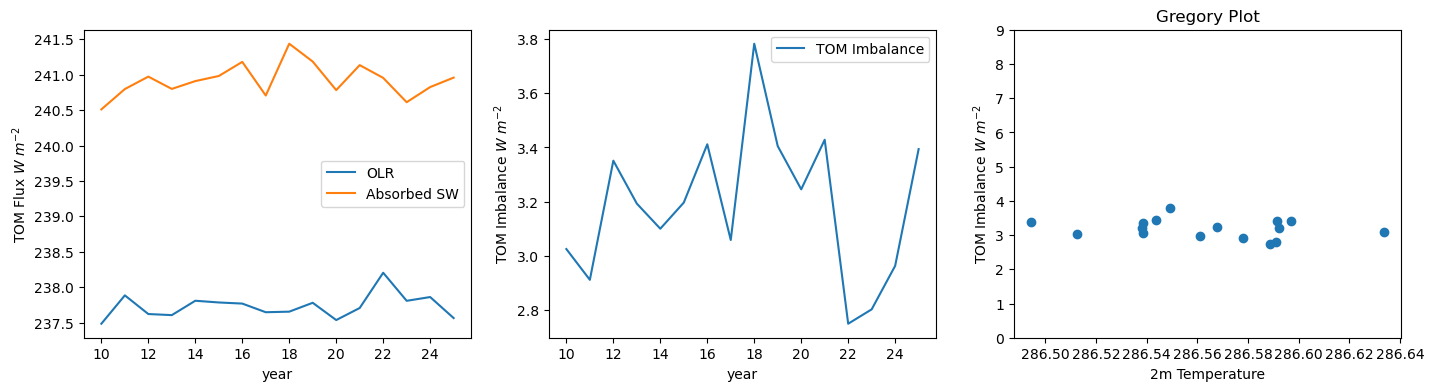

In [10]:
# Now we'll look at these variables, note it doesn't make much sense to make a gregory plot for a fixed SST run. But we'll do it anyway...
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 4))
FLNTglob.plot(ax=ax1,label='OLR')
FSNTglob.plot(ax=ax1,label='Absorbed SW')
ax1.legend()
ax1.set_ylabel('TOM Flux $W~m^{-2}$')
imbalanceTOM.plot(ax=ax2,label='TOM Imbalance')
ax2.legend()
ax3.scatter(TREFHTglob.values,imbalanceTOM) # the temperature is not a difference for this gregory plot, though feel free to make it so by removing the control mean
ax3.set_ylim((0,9))
ax3.set_title('Gregory Plot')
ax3.set_xlabel('2m Temperature')
ax2.set_ylabel('TOM Imbalance $W~m^{-2}$')
ax3.set_ylabel('TOM Imbalance $W~m^{-2}$')
fig.savefig("ControlfixedSST_TOMimbalance.png",
            bbox_inches="tight", dpi=300)

In [11]:
# Examine timeseries from the CMIP6 QuadrupleCO2 run, redo with your run if it is coupled
FSNTglob=(dsP.FSNT.mean(dim='lon')*dsP.gw).sum(dim='lat')/2
FLNTglob=(dsP.FLNT.mean(dim='lon')*dsP.gw).sum(dim='lat')/2
imbalanceTOM=(FSNTglob-FLNTglob)
TREFHTglob=compute_global(dsP.TREFHT,dsP.gw)
TREFHTglobC=compute_global(dsC.TREFHT,dsC.gw)  #from the piControl (don't change this)

# convert to annual means
FSNTglob=FSNTglob.groupby('time.year').mean('time')
FLNTglob=FLNTglob.groupby('time.year').mean('time')
imbalanceTOM=imbalanceTOM.groupby('time.year').mean('time')
TREFHTglob=TREFHTglob.groupby('time.year').mean('time')
TREFHTglobC=TREFHTglobC.groupby('time.year').mean('time')

Try subtracting the piControl temperature from your Experiment for a proper gregory plot
y intercept is  7.707200124220555 W m2
x intercept is  7.525227542211498 deg C


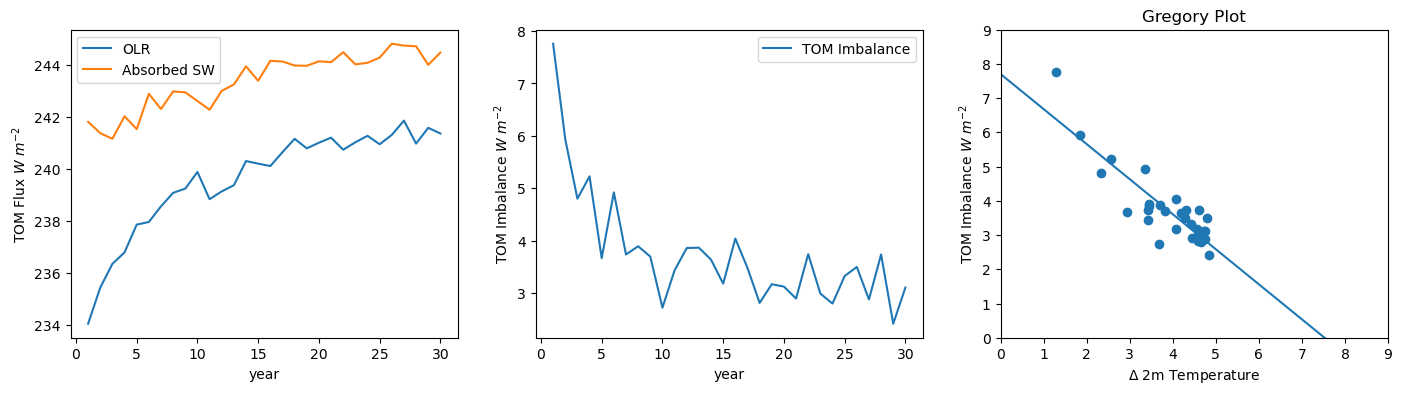

In [12]:
# Example Plots of the 4XCO2 runs. Replace with yours if it is coupled
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 4))
FLNTglob.plot(ax=ax1,label='OLR')
FSNTglob.plot(ax=ax1,label='Absorbed SW')
ax1.legend()
ax1.set_ylabel('TOM Flux $W~m^{-2}$')
imbalanceTOM.plot(ax=ax2,label='TOM Imbalance')
ax2.legend()
print('Subtracting the piControl temperature from your Experiment for a proper gregory plot')
dT=TREFHTglob.values-TREFHTglobC.values
(m, b)=np.polyfit(dT,imbalanceTOM.values,deg=1)
x=line_x = np.linspace(0, 9, 10)
fit = m * x + b
ax3.scatter(dT,imbalanceTOM)
ax3.plot(x,fit)
ax3.set_ylim((0,9))
ax3.set_xlim((0,9))
ax3.set_title('Gregory Plot')
ax3.set_xlabel('$\Delta$ 2m Temperature')
ax2.set_ylabel('TOM Imbalance $W~m^{-2}$')
ax3.set_ylabel('TOM Imbalance $W~m^{-2}$')
fig.savefig("QuadrupleCO2_TOMimbalance.png",
            bbox_inches="tight", dpi=300)
print('y intercept is ', b , 'W m2')
print('x intercept is ', -b/m, 'deg C')

## FILL IN BELOW

In [ ]:
# Now do the same for your run feel free to change the variable Esst to something you like
# THIS WON'T run until you fill in the options below
username=''
case=''
exper=''
Esstdict,dsEsst=compute_global_means(username,case,exper)
Esstdict

In [ ]:
# copy and paste the parts above, such as: 

FSNTglob=(dsEsst.FSNT.mean(dim='lon')*dsCsst.gw).sum(dim='lat')/2
FLNTglob=(dsEsst.FLNT.mean(dim='lon')*dsCsst.gw).sum(dim='lat')/2
imbalanceTOM=(FSNTglob-FLNTglob)
TREFHTglob=compute_global(dsEsst.TREFHT,dsCsst.gw)

# convert to annual means
FSNTglob=FSNTglob.groupby('time.year').mean('time')
FLNTglob=FLNTglob.groupby('time.year').mean('time')
imbalanceTOM=imbalanceTOM.groupby('time.year').mean('time')
TREFHTglob=TREFHTglob.groupby('time.year').mean('time')